In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

## statistics
from scipy.stats import zscore
import statsmodels.formula.api as sm

## ML
import PyComplexHeatmap as pyc
from PyComplexHeatmap.utils import define_cmap
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


## Extra
from anndata import read_h5ad

## Load Data

In [2]:
## Load plasma-tissue paired samples
ad = read_h5ad('/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/intermediate/anndata/2024_06_28_pilot_tpb_anndata.h5ad')

## Load plasma-tissue paired samples' meta-data
columns = ["unique_sample_id", "sample_id", "age","qc_status", "histological_subtype", "flowcell", "molecule_file_path", "g360_max_maf_pct"]
meta_info = pd.read_csv("/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/resources/metadata/2024-06-23_updated_pilot_TPB_and_cf_Ep1_Epiv2p0_with_epiTFgamma.tsv", sep="\t").\
    loc[:,columns]
    
## combine meta-data
tissue_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__tumor_tissue") ').\
    merge(meta_info, how="left", on="unique_sample_id")

plasma_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__plasma_patient") ').\
    merge(meta_info, how="left", on="unique_sample_id")

plasma_tissue_meta = pd.concat([plasma_meta,tissue_meta],axis=0)
print(f"The shape of plasma-tissue meta-data before filtering is {plasma_tissue_meta.shape}")

## load plasma-tissue paired samples' region scores
plasma_tissue_lung_region_scores = pd.read_csv("/home/eforouzmand/repos/gh-eforouzmand/2024-Jul-09-Tissue-Plasma-Comparisons/tissue_plasma_lung_region_scores.tsv", sep="\t")

## Missing sample filtering
missing_patient_id_specimen = plasma_tissue_meta.query('~sample_id.isin(@plasma_tissue_lung_region_scores.run_sample_id) ').patient_id_specimen.iloc[0].split("__")[0]
missing_run_sample_id = plasma_tissue_meta.query(' patient_id_specimen.str.startswith(@missing_patient_id_specimen) ').sample_id

plasma_tissue_meta = plasma_tissue_meta.query(' ~sample_id.isin(@missing_run_sample_id) ').\
    set_index("sample_id")

print(f"Meta-data shape after filtering: {plasma_tissue_meta.shape}")

plasma_tissue_lung_region_scores = plasma_tissue_lung_region_scores.query(' ~run_sample_id.isin(@missing_run_sample_id) ').\
    set_index("run_sample_id")

print(f"Region score data shape after filtering: {plasma_tissue_lung_region_scores.shape}")

## Load clustering information of plasma-tissue pairs
plasma_tissue_cluster = pd.read_csv("/screening/notebooks/zhuang/summer_2024/data/plasma_tissue_cluster.tsv", sep="\t").\
    set_index("run_sample_id")

The shape of plasma-tissue meta-data before filtering is (50, 17)
Meta-data shape after filtering: (48, 16)
Region score data shape after filtering: (48, 3598)


In [3]:
## region meta-info
tissue_regions_meta = pd.read_csv('/screening/analysis/2024_03_29_MCD_intermediate_files/intermediate/s3_region_design/s3_v1.2b_V6_noCntrl_and_tcga_overlap_EP1_full.tsv', sep='\t')
tissue_regions_meta.head()

## lung model
s3_v4_model = pd.read_table("/home/eforouzmand/repos/gh-eforouzmand/2024-Jun-12-Lung-S3-in-region-discovery/intermediate_data/CANDIDATE_S3_Lung_-_V4.model_file.98_spec_set_on_s3_data.tsv")

## Visualize assigned clusters of each pair for each histological subtype

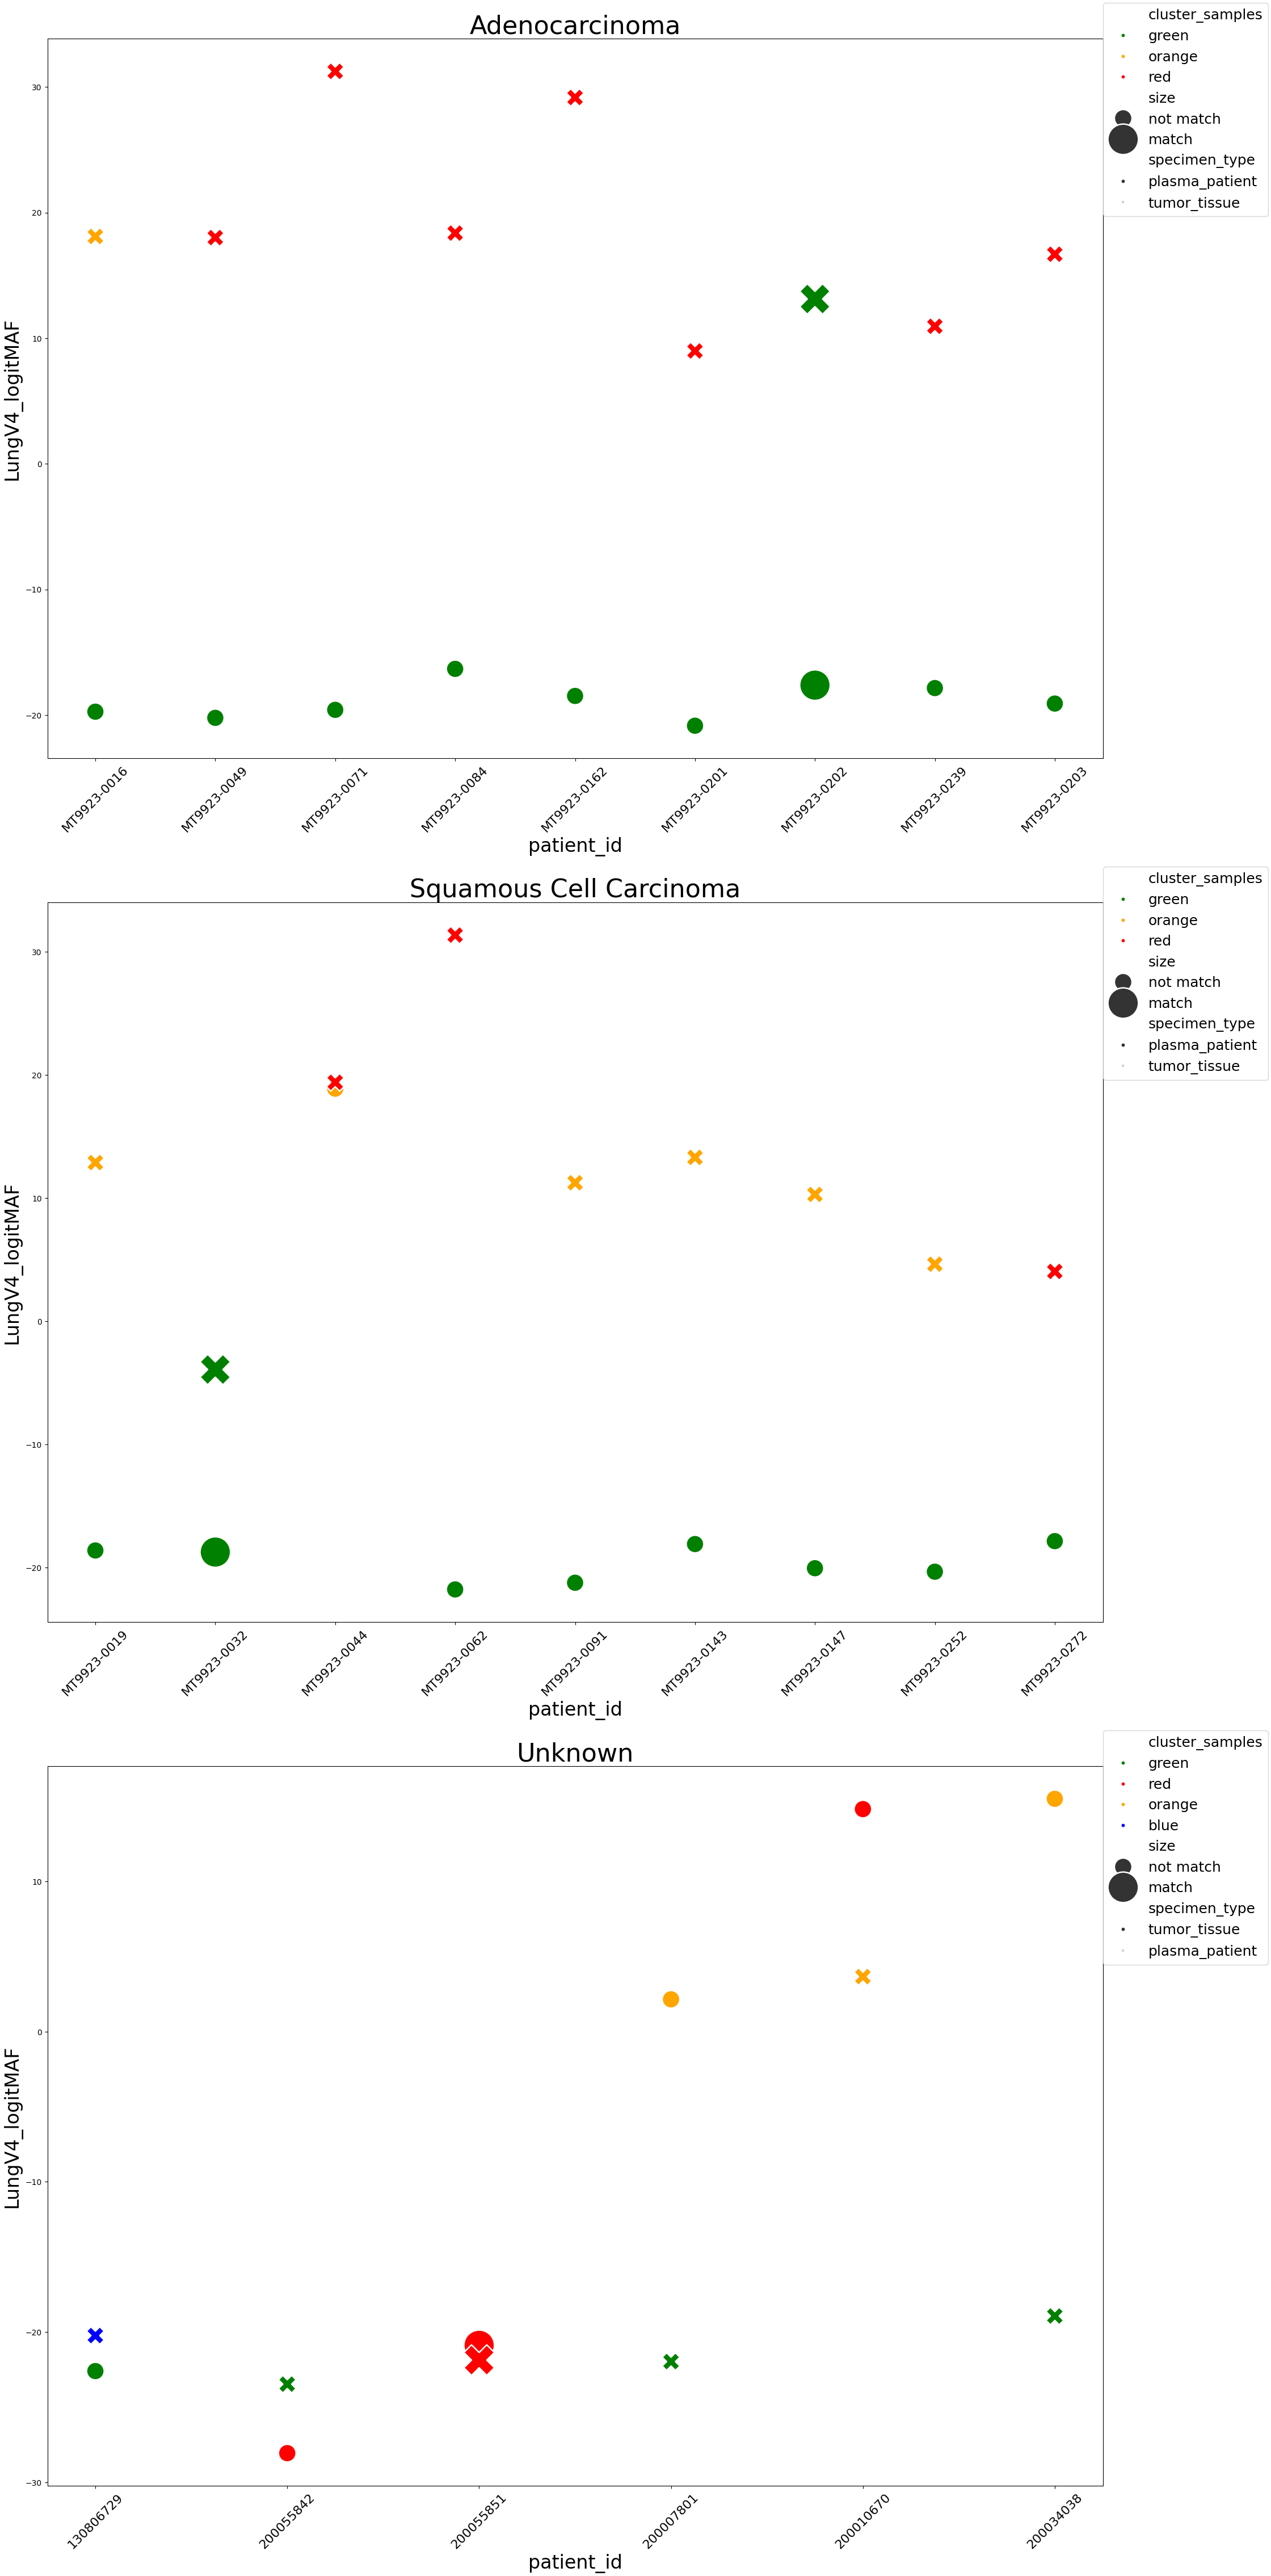

In [4]:
y_label = "LungV4_logitMAF"

custom_palette = {"green": "green",
                  "orange": "orange",
                  "red" : "red",
                  "blue": "blue"}

size_mapping = {0: "not match",
                1: "match"}

plasma_tissue_cluster["size"] = plasma_tissue_cluster["matched"].map(size_mapping)

fig, axes = plt.subplots(3,1,figsize=(24,56))

with plt.style.context('_classic_test_patch'):
     
    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = plasma_tissue_cluster.query('histological_subtype == "adenocarcinoma"'),
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[0])

    axes[0].set_xlabel('patient_id', fontsize=24)
    axes[0].set_ylabel(y_label, fontsize=24)
    axes[0].set_title('Adenocarcinoma', fontsize=32)
    axes[0].tick_params(axis="x", labelsize=16)
    axes[0].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = plasma_tissue_cluster.query('histological_subtype == "squamous_cell_carcinoma"'),
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[1])

    axes[1].set_xlabel('patient_id', fontsize=24)
    axes[1].set_ylabel(y_label, fontsize=24)
    axes[1].set_title('Squamous Cell Carcinoma', fontsize=32)
    axes[1].tick_params(axis="x", labelsize=16)
    axes[1].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})

    
    sns.scatterplot(x = "patient_id",
                    y = "LungV4_logitMAF",
                    hue = "cluster_samples",
                    palette = custom_palette,
                    data = plasma_tissue_cluster.query('histological_subtype == "unknown"'),
                    style = "specimen_type",
                    size = "size",
                    sizes = (1500, 500),
                    ax = axes[2])

    axes[2].set_xlabel('patient_id', fontsize=24)
    axes[2].set_ylabel(y_label, fontsize=24)
    axes[2].set_title('Unknown', fontsize=32)
    axes[2].tick_params(axis="x", labelsize=16)
    axes[2].legend(bbox_to_anchor=(1,1.05), loc="upper left", borderaxespad=0, prop={"size": 18})
    

    for ax in axes.flatten():
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

## Load cancer-free & lung samples for the discovery set

In [5]:
## Load cancer-free samples
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

df_cf = df_ldt.loc[:,["unique_sample_id","sample_group"]+region_ids].\
    query('sample_group == "cancer_free"').\
    drop("sample_group",axis=1).\
    set_index("unique_sample_id").\
    loc[:,s3_v4_model.region_id]

print(f"The shape of the cancer-free sample data from the discovery set is {df_cf.shape}")

The shape of the cancer-free sample data from the discovery set is (995, 3598)


## On-off regions

In [6]:
cf_means = df_cf.mean(axis=0)
cf_stds = df_cf.std(axis=0)

meta_columns = ["specimen_type","patient_id","histological_subtype"]

plasma_tissue_lung_region_scores = pd.merge(plasma_tissue_lung_region_scores, plasma_tissue_cluster[meta_columns], how="left", left_index=True, right_index=True)

### Compute SNR (across all)

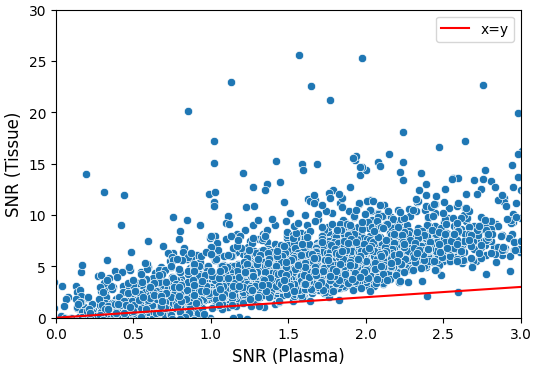

In [7]:
tissue_lung_region_scores = plasma_tissue_lung_region_scores.query(' specimen_type == "tumor_tissue" ').\
    drop(meta_columns, axis=1)

plasma_lung_region_scores = plasma_tissue_lung_region_scores.query(' specimen_type == "plasma_patient" ').\
    drop(meta_columns, axis=1)

## Compute SNR of each regions
snrs = pd.DataFrame({"snr_tissue": (tissue_lung_region_scores.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0),
                     "snr_plasma": (plasma_lung_region_scores.mean(axis=0) - df_cf.mean(axis=0))/df_cf.std(axis=0)},
                     index = plasma_tissue_lung_region_scores.columns)
    

fig, axes = plt.subplots(figsize=(6,4))
        
with plt.style.context('_classic_test_patch'):
        
    sns.scatterplot(x="snr_plasma",
                    y="snr_tissue",
                    data=snrs,
                    ax=axes)
    axes.set_xlabel("SNR (Plasma)", fontsize=12)
    axes.set_xlim([0,3])
    axes.set_ylabel("SNR (Tissue)",fontsize=12)
    axes.set_ylim([0,30])

    axes.axline((0,0), slope=1, linestyle='-', color='red', label="x=y")

    axes.legend()    

In [8]:
run = True
#tissue_mutiplier = 1
on_off_tissue_mutiplier = {}
thresholds = [round(i,1) for i in np.arange(0.5,5.5,0.5)]
logics = ["And","Or", "Neither", "Tissue_Only", "Plasma_Only"]

for tissue_mutiplier in range(1,6): ## 1-5

    on_off_dict = {}

    for threshold in thresholds:
        
        arr = np.zeros((len(cf_means), len(logics)))
        
        for id in plasma_tissue_lung_region_scores.patient_id.unique():
            on_off = plasma_tissue_lung_region_scores.query(' patient_id == @id ').\
                sort_values("specimen_type").\
                drop(meta_columns, axis=1).\
                apply(lambda x: (x-cf_means)/cf_stds, axis=1)
            
        
            plasma = on_off.iloc[0,:]
            tissue = on_off.iloc[1,:]
        
            arr[(plasma >= threshold)  & (tissue >= tissue_mutiplier*threshold) , 0] += 1
            arr[ (plasma >= threshold) | (tissue >= tissue_mutiplier*threshold), 1] += 1
            arr[ ~(plasma >= threshold) & ~(tissue >= tissue_mutiplier*threshold), 2] += 1
            arr[ ~(plasma >= threshold) & (tissue >= tissue_mutiplier*threshold), 3] += 1
            arr[ (plasma >= threshold) & ~(tissue >= tissue_mutiplier*threshold), 4] += 1
        
        arr = arr/len(plasma_tissue_lung_region_scores.patient_id.unique())
        on_off_dict["snr_"+str(threshold)] = pd.DataFrame(arr,
                                                          index = cf_means.index,
                                                          columns = logics)

    on_off_tissue_mutiplier["mutiplier_"+str(tissue_mutiplier)] = on_off_dict

### Proportion of regions that are:

- on in both plasma and tissue
- on either in plasma or tissue
- on only in tissue
- on only in plasma

- Hyperparameter: "on" frequency, SNR threshold, tissue_mutiplier.

In [9]:
freq_threshold = 0.8
summary = pd.DataFrame()

for multiplier, on_off_dict in on_off_tissue_mutiplier.items():

    logics_summary = pd.DataFrame()
    
    And_count = []
    Or_count = []
    Tissue_Only_count = []
    Plasma_Only_count = []
    
    for key, value in on_off_dict.items():
        
        threshold = float(key.split("_")[1])
        
        tmp = value.agg(['median','mean','max','min']).\
                T.\
                assign(snr_threshold = threshold).\
                reset_index(names="logics")
    
        logics_summary = pd.concat([logics_summary, tmp],axis=0)
    
        And_count.append(len(value.query('And >= @freq_threshold')))
        Or_count.append(len(value.query('Or >= @freq_threshold')))
        Tissue_Only_count.append(len(value.query('Tissue_Only >= @freq_threshold')))
        Plasma_Only_count.append(len(value.query('Plasma_Only >= @freq_threshold')))
    
    count_summary = pd.DataFrame({"tissue_multiplier": float(multiplier.split("_")[1]),
                                  "snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count),#/len(cf_means),
                                   "Or_count": np.array(Or_count),#/len(cf_means),
                                   "Tissue_Only_count": np.array(Tissue_Only_count),#/len(cf_means),
                                   "Plasma_Only_count": np.array(Plasma_Only_count)})#/len(cf_means)})
    
    summary = pd.concat([summary, count_summary],axis=0)

summary = summary.sort_values(by=["snr_threshold","tissue_multiplier"], ascending=[True,True]).\
    assign(tissue_multiplier = lambda df: df["tissue_multiplier"].astype("object"))

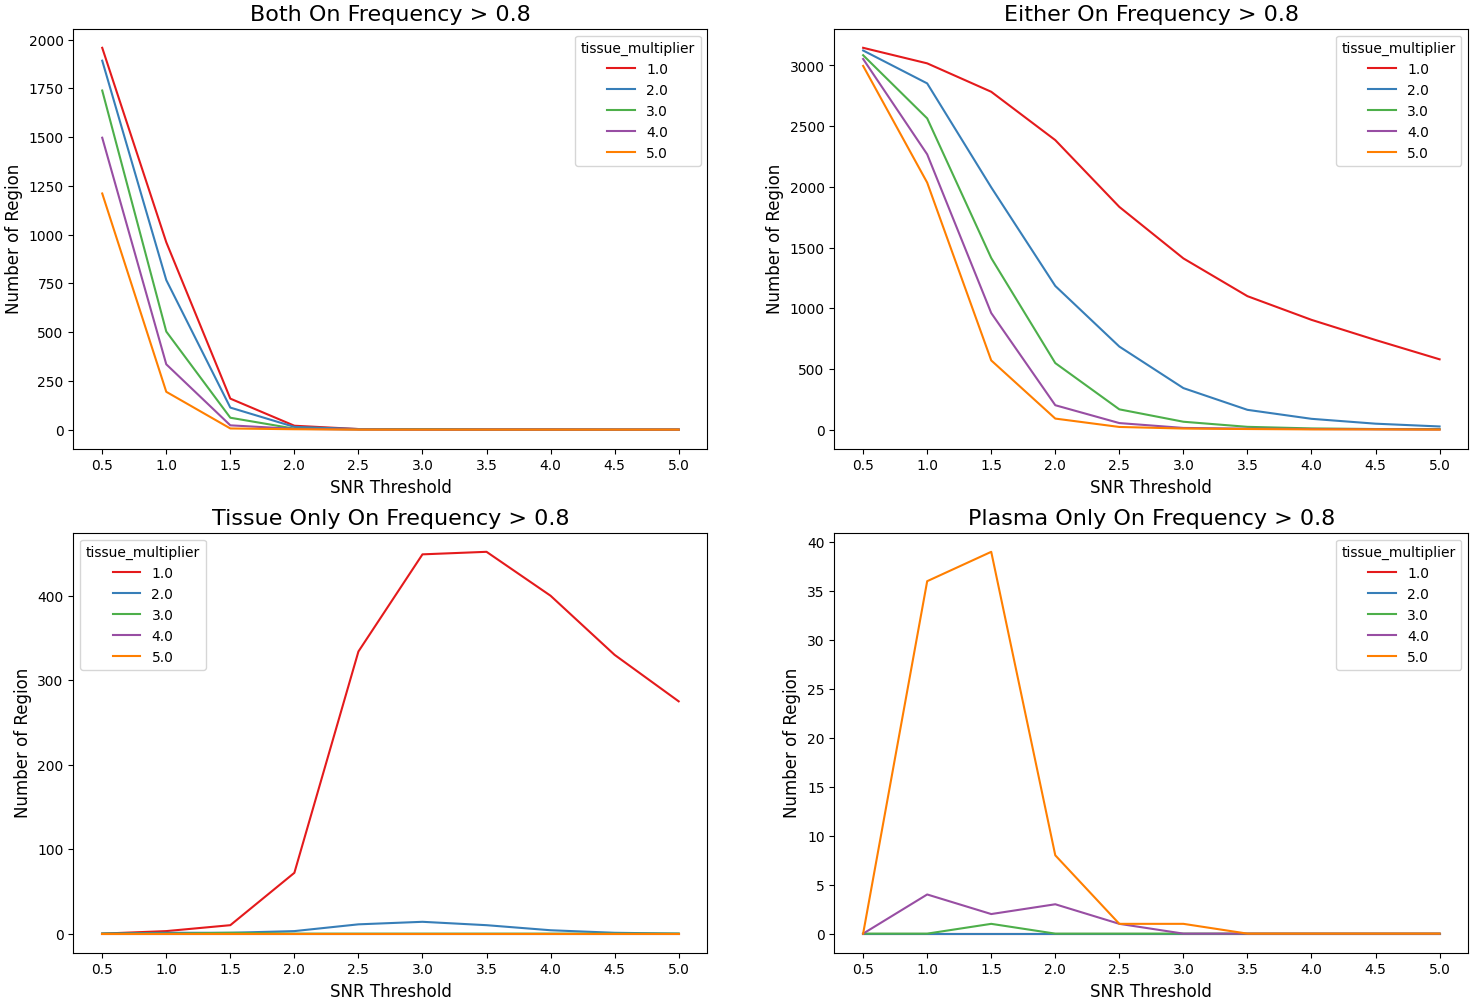

In [10]:
fig, axes = plt.subplots(2,2,figsize=(18,12))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="snr_threshold",
                     y="And_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary,
                     ax=axes[0,0])
    
    axes[0,0].set_title(f"Both On Frequency > {freq_threshold:.1f}",fontsize=16)
    axes[0,0].set_xticks(thresholds)
    axes[0,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Or_count",
                 hue="tissue_multiplier",
                 palette="Set1",
                 data=summary,
                 ax=axes[0,1])
    
    axes[0,1].set_title(f"Either On Frequency > {freq_threshold:.1f}", fontsize=16)
    axes[0,1].set_xticks(thresholds)
    axes[0,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,1].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                     y="Tissue_Only_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary,
                     ax=axes[1,0])
    
    axes[1,0].set_title(f"Tissue Only On Frequency > {freq_threshold:.1f}", fontsize=16)
    axes[1,0].set_xticks(thresholds)
    axes[1,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                     y="Plasma_Only_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary,
                     ax=axes[1,1])
    
    axes[1,1].set_title(f"Plasma Only On Frequency > {freq_threshold:.1f}", fontsize=16)
    axes[1,1].set_xticks(thresholds)
    axes[1,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,1].set_ylabel("Number of Region", fontsize=12)

In [11]:
freq_threshold_reverse = 0.2
summary_reverse = pd.DataFrame()
region_summary = {}

for multiplier, on_off_dict in on_off_tissue_mutiplier.items():

    logics_summary = pd.DataFrame()
    
    And_count = []
    #And_region = []
    Or_count = []
    #Or_region = []
    Tissue_Only_count = []
    #Tissue_Only_region = []
    Plasma_Only_count = []
    #Plasma_Only = []
    
    for key, value in on_off_dict.items():
        
        threshold = float(key.split("_")[1])
        
        tmp = value.agg(['median','mean','max','min']).\
                T.\
                assign(snr_threshold = threshold).\
                reset_index(names="logics")
    
        logics_summary = pd.concat([logics_summary, tmp],axis=0)
    
        And_count.append(len(value.query('And < @freq_threshold_reverse')))
        #And_region.append(value.query('And < @freq_threshold_reverse').index)
        
        Or_count.append(len(value.query('Or < @freq_threshold_reverse')))
        #Or_region.append(value.query('Or < @freq_threshold_reverse').index)
        
        Tissue_Only_count.append(len(value.query('Tissue_Only < @freq_threshold_reverse')))
        #Tissue_Only_region.append(value.query('Tissue_Only < @freq_threshold_reverse').index)

        
        Plasma_Only_count.append(len(value.query('Plasma_Only < @freq_threshold_reverse')))
        #Plasma_Only_region.append(value.query('Plasma_Only < @freq_threshold_reverse').index)
    
    count_summary = pd.DataFrame({"tissue_multiplier": float(multiplier.split("_")[1]),
                                  "snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count),#/len(cf_means),
                                   "Or_count": np.array(Or_count),#/len(cf_means),
                                   "Tissue_Only_count": np.array(Tissue_Only_count),#/len(cf_means),
                                   "Plasma_Only_count": np.array(Plasma_Only_count)})#/len(cf_means)})
    
    summary_reverse = pd.concat([summary_reverse, count_summary],axis=0)

summary_reverse = summary_reverse.sort_values(by=["snr_threshold","tissue_multiplier"], ascending=[True,True]).\
    assign(tissue_multiplier = lambda df: df["tissue_multiplier"].astype("object"))

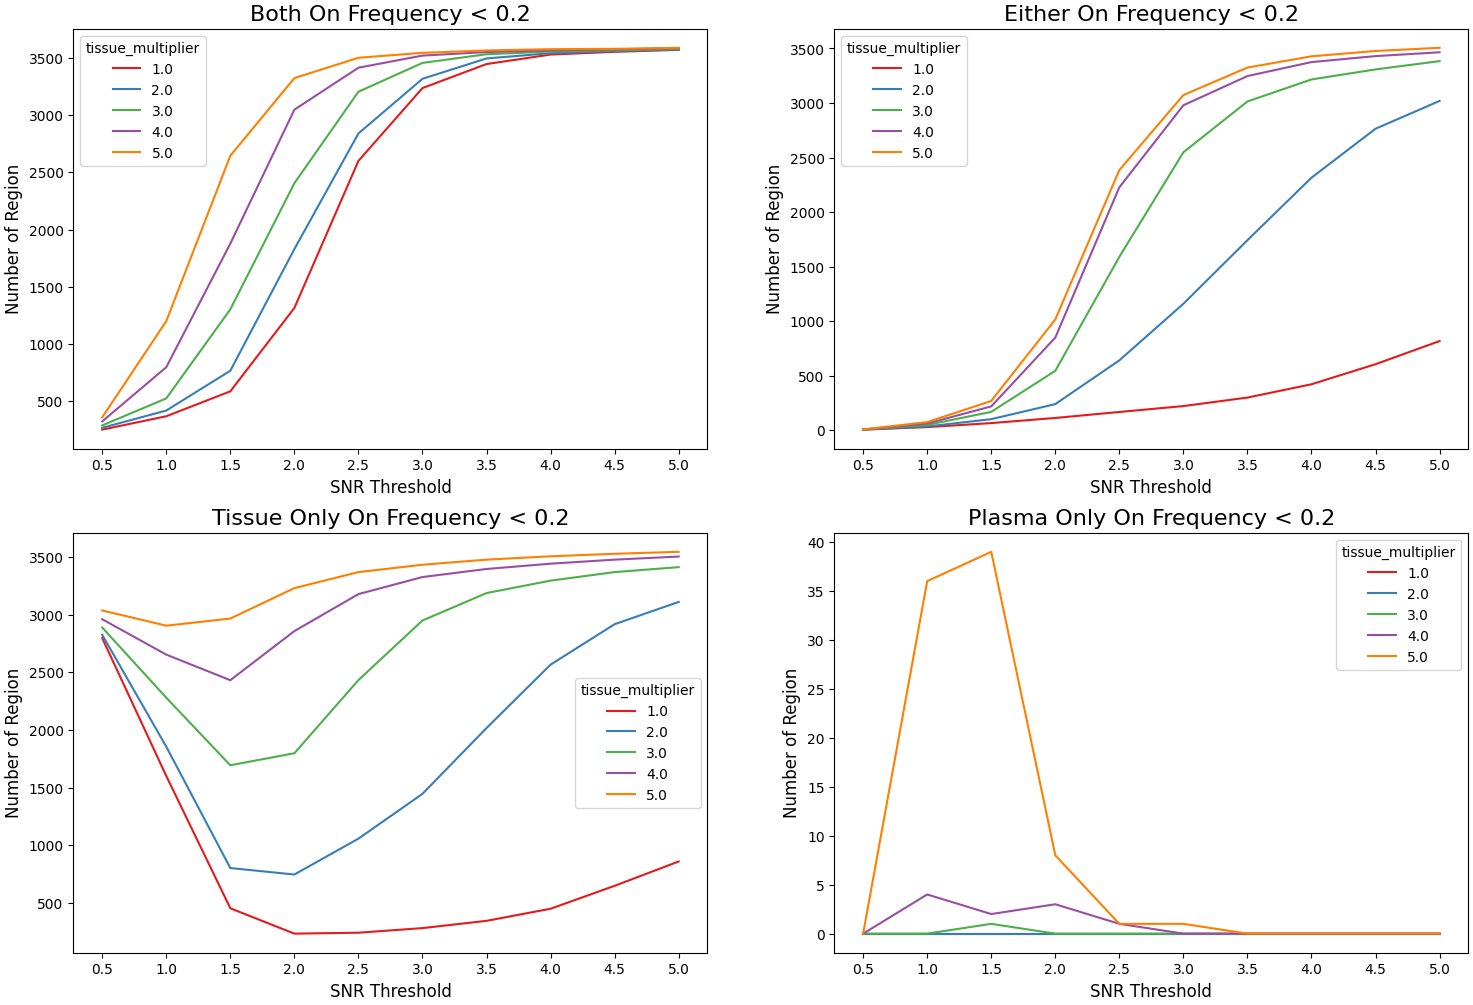

In [12]:
fig, axes = plt.subplots(2,2,figsize=(18,12))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="snr_threshold",
                     y="And_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary_reverse,
                     ax=axes[0,0])
    
    axes[0,0].set_title(f"Both On Frequency < {freq_threshold_reverse:.1f}",fontsize=16)
    axes[0,0].set_xticks(thresholds)
    axes[0,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Or_count",
                 hue="tissue_multiplier",
                 palette="Set1",
                 data=summary_reverse,
                 ax=axes[0,1])
    
    axes[0,1].set_title(f"Either On Frequency < {freq_threshold_reverse:.1f}", fontsize=16)
    axes[0,1].set_xticks(thresholds)
    axes[0,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,1].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                     y="Tissue_Only_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary_reverse,
                     ax=axes[1,0])
    
    axes[1,0].set_title(f"Tissue Only On Frequency < {freq_threshold_reverse:.1f}", fontsize=16)
    axes[1,0].set_xticks(thresholds)
    axes[1,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                     y="Plasma_Only_count",
                     hue="tissue_multiplier",
                     palette="Set1",
                     data=summary,
                     ax=axes[1,1])
    
    axes[1,1].set_title(f"Plasma Only On Frequency < {freq_threshold_reverse:.1f}", fontsize=16)
    axes[1,1].set_xticks(thresholds)
    axes[1,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,1].set_ylabel("Number of Region", fontsize=12)

## Jaccard similarity of On-off regions between plasma and tissue

In [13]:
tissue_mutiplier = 1
similarity = pd.DataFrame()

for threshold in thresholds:
    jaccard = []
    
    for id in plasma_tissue_lung_region_scores.patient_id.unique():
                on_off = plasma_tissue_lung_region_scores.query(' patient_id == @id ').\
                    sort_values("specimen_type").\
                    drop(meta_columns, axis=1).\
                    apply(lambda x: (x-cf_means)/cf_stds, axis=1)
        
            
                plasma = on_off.iloc[0,:]
                tissue = on_off.iloc[1,:]
    
                intersection = ( (plasma >= threshold) & (tissue >= tissue_mutiplier*threshold) ).sum()
                
                union = ( (plasma >= threshold) | (tissue >= tissue_mutiplier*threshold) ).sum()
                
                jaccard.append(intersection/union)

    similarity = pd.concat([similarity, pd.DataFrame(jaccard).T],axis=0)

similarity.columns = plasma_tissue_lung_region_scores.patient_id.unique()
similarity.index = thresholds

In [14]:
df_anno = plasma_tissue_cluster.copy()
df_anno = df_anno[["patient_id","matched", "histological_subtype"]].drop_duplicates().\
    set_index("patient_id")

similarity = similarity.loc[:,list(df_anno.index)]

row_anno = pd.DataFrame({"SNR_threshold":thresholds},
                        index = thresholds)

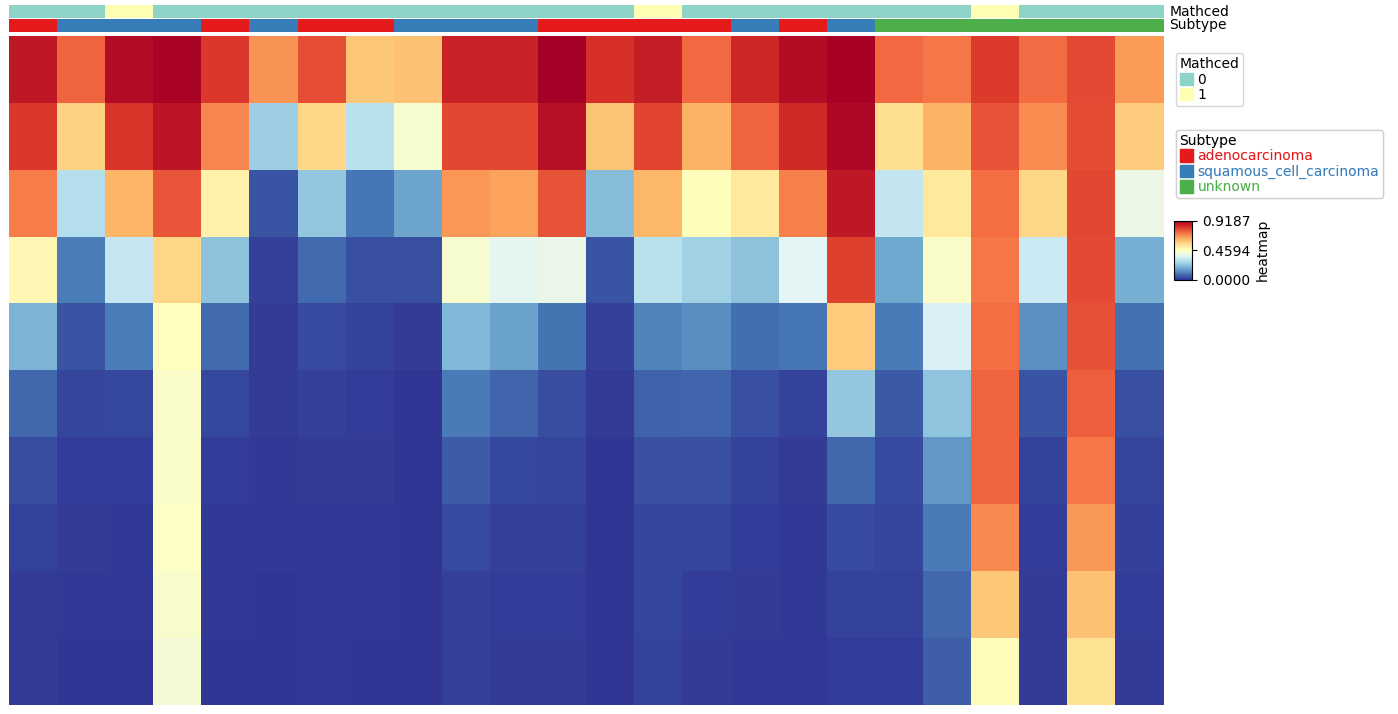

In [15]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  axis=1, 
                                  verbose=False)

#row_annot = pyc.HeatmapAnnotation(Threshold=pyc.anno_simple(row_anno.SNR_threshold),
                                  #axis=1, 
                                  #verbose=False)

cm = pyc.ClusterMapPlotter(data=similarity, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=False,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=4, 
                           col_split_gap=1, 
                           col_cluster=False,
                           row_cluster=False,
                           #row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

cm.ax_heatmap.set_xticks(range(len(similarity.columns)))
cm.ax_heatmap.set_xticklabels(similarity.columns)

cm.ax_heatmap.set_yticks(range(len(row_anno.SNR_threshold)))
cm.ax_heatmap.set_yticklabels(row_anno.SNR_threshold)

plt.show()

In [16]:
## x-axis = SNR threshold
## value = boxplot of different tissue_multipliers
## freq_threshold = 0.5

In [17]:
on_off_dict['snr_0.5'].head()
   

And        Or   Neither  Tissue_Only  Plasma_Only
s3_region_26389  0.875000  1.000000  0.000000     0.000000     0.125000
s3_region_22508  0.875000  1.000000  0.000000     0.041667     0.083333
s3_region_22604  0.708333  0.958333  0.041667     0.083333     0.166667
s3_region_26760  0.291667  0.833333  0.166667     0.083333     0.458333
s3_region_17285  0.458333  1.000000  0.000000     0.083333     0.458333

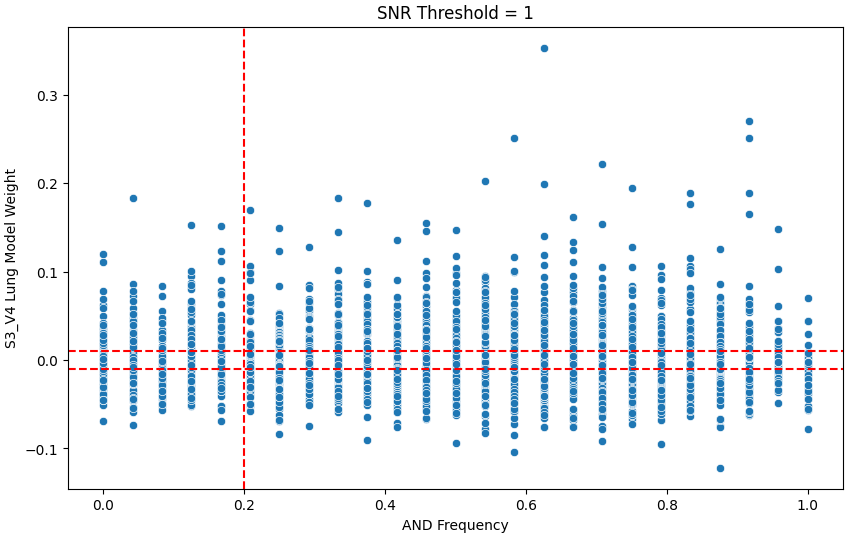

In [96]:
tmp = on_off_tissue_mutiplier['mutiplier_3']['snr_1.0'].\
    reset_index(names="region_id").\
    merge(s3_v4_model, on="region_id",how='left')

abs_weight_quantile = 0.3
freq_threshold = 0.2

fig, axes = plt.subplots(figsize=(10,6))
        
with plt.style.context('_classic_test_patch'):
        
   
    sns.scatterplot(x="And",
                    y="weight",
                    data=tmp,
                    ax=axes)

    axes.set_title("SNR Threshold = 1")
    axes.set_xlabel("AND Frequency")
    axes.set_ylabel("S3_V4 Lung Model Weight")

    
    plt.axvline(freq_threshold, 0, linestyle="--", color="red")
    #plt.axvline(1, 0, linestyle="--", color="red")
    plt.axhline(s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")
    plt.axhline(-s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")

In [19]:
abs_weight_quantile = 0.3
freq_threshold = 0.5
region_classification = {}

for key, val in on_off_tissue_mutiplier['mutiplier_1'].items():
    
    val = val.\
        reset_index(names="region_id").\
        merge(s3_v4_model, on="region_id",how='left')


    ## Classify regions
    hi_freq_lo_wt = val.query('And >= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    hi_freq_hi_wt = val.query('And >= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id
    
    lo_freq_lo_wt = val.query('And < @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    lo_freq_hi_wt = val.query('And < @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id

    region_classification[key] = {"hi_freq_lo_wt": hi_freq_lo_wt, ## signals in tissue that are NOT captured by the model
                                  "hi_freq_hi_wt": hi_freq_hi_wt, ## signals in tissue that are captuered by the model
                                  "lo_freq_lo_wt": lo_freq_lo_wt, ## signals in plasma that are NOT captured by the model
                                  "lo_freq_hi_wt": lo_freq_hi_wt} ## signals in plasma that are captureed by the model

In [20]:
region_classification['snr_1.0'].keys()

dict_keys(['hi_freq_lo_wt', 'hi_freq_hi_wt', 'lo_freq_lo_wt', 'lo_freq_hi_wt'])

In [21]:
region_classification_count = pd.DataFrame()

for _, snr_threshold in  region_classification.items():
    count_dict = {}
    for key, region in snr_threshold.items():
        count_dict[key] = len(region)

    region_classification_count = pd.concat([ region_classification_count, pd.Series(count_dict) ], axis=1)

region_classification_count = region_classification_count.T.\
    reset_index(drop=True).\
    assign(thresholds = thresholds)

In [22]:
region_classification_count

hi_freq_lo_wt  hi_freq_hi_wt  lo_freq_lo_wt  lo_freq_hi_wt  thresholds
0            890           2071            190            447         0.5
1            791           1845            289            673         1.0
2            521           1170            559           1348         1.5
3            136            279            944           2239         2.0
4             28             56           1052           2462         2.5
5              8             13           1072           2505         3.0
6              6              5           1074           2513         3.5
7              2              2           1078           2516         4.0
8              2              2           1078           2516         4.5
9              0              1           1080           2517         5.0

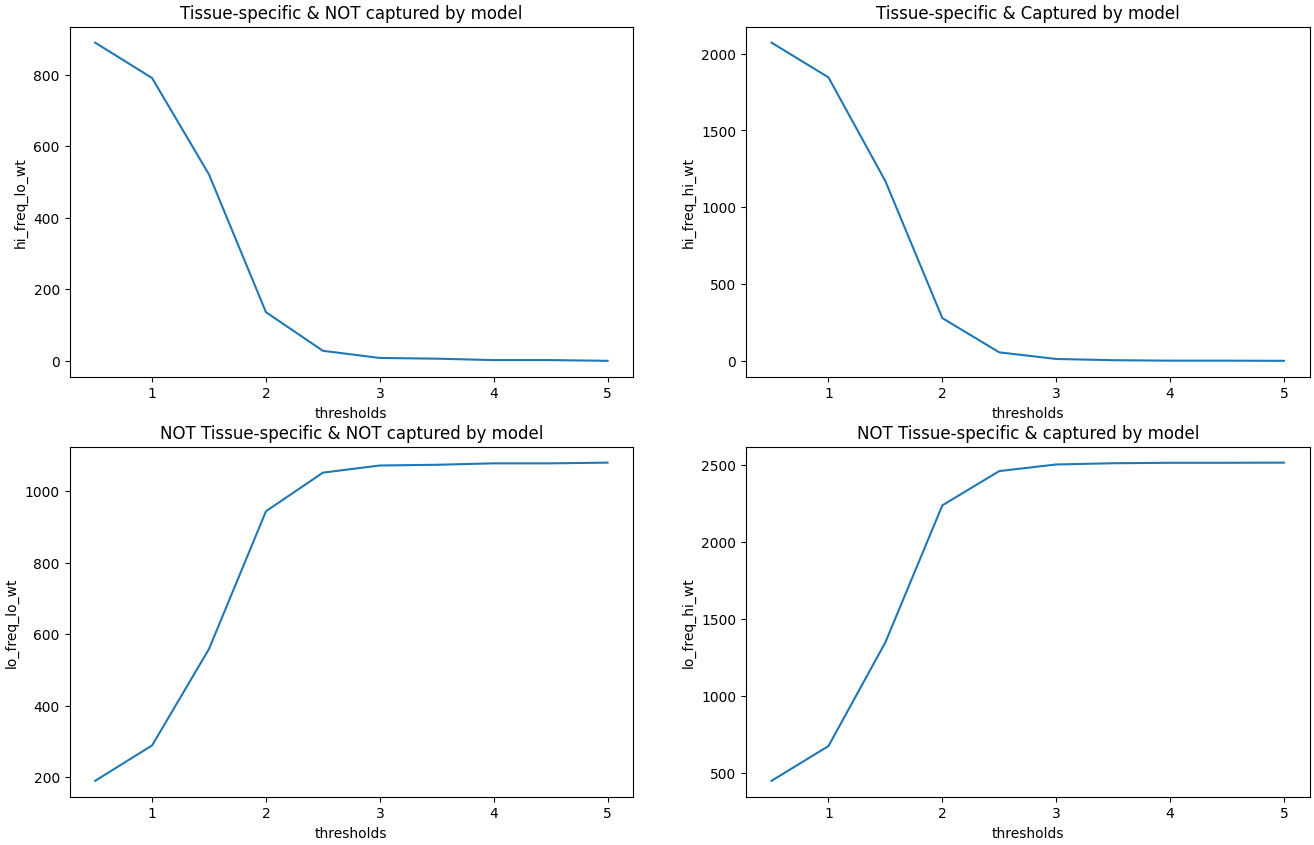

In [23]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="thresholds",
                 y="hi_freq_lo_wt",
                 data=region_classification_count,
                 ax=axes[0,0])
    
    axes[0,0].set_title("Tissue-specific & NOT captured by model")

    sns.lineplot(x="thresholds",
                 y="hi_freq_hi_wt",
                 data=region_classification_count,
                 ax=axes[0,1])
    
    axes[0,1].set_title("Tissue-specific & Captured by model")

    sns.lineplot(x="thresholds",
                 y="lo_freq_lo_wt",
                 data=region_classification_count,
                 ax=axes[1,0])
    
    axes[1,0].set_title("NOT Tissue-specific & NOT captured by model")

    sns.lineplot(x="thresholds",
                 y="lo_freq_hi_wt",
                 data=region_classification_count,
                 ax=axes[1,1])
    
    axes[1,1].set_title("NOT Tissue-specific & captured by model")

In [24]:
on_off_dict.keys()

## For each threshold, extract regions that are only on in tissue (e.g. frequency = 0.7), 
## Use lung samples in the discovery set
## 

dict_keys(['snr_0.5', 'snr_1.0', 'snr_1.5', 'snr_2.0', 'snr_2.5', 'snr_3.0', 'snr_3.5', 'snr_4.0', 'snr_4.5', 'snr_5.0'])

In [25]:
#on_off_dict["snr_0.5"].Tissue_Only.quantile(0.9)1

## Explore are regions only on in tissue samples are "on" in other high maf plasma samples

### Load lung samples from the discovery set

In [26]:
## Prediction from Lung Model: MB_S3_V4
called_samples = pd.read_csv("../data/called_discovery_lung_samples.tsv",sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "FP", "TP"))

not_called_samples = pd.read_csv("../data/not_called_discovery_lung_samples.tsv", sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "TN", "FN"))

lung_MB_S3_V4 =  pd.concat([called_samples, not_called_samples],axis=0).\
    loc[:,["unique_sample_id","called"]].\
    set_index("unique_sample_id")

df_lung = df_ldt.loc[:,["unique_sample_id","sample_group","age","sex","histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']+region_ids].\
    query('sample_group == "lung"').\
    set_index("unique_sample_id").\
    assign(histological_subtype = lambda df: np.where(df['histological_subtype'].isin(['adenocarcinoma', 'squamous_cell_carcinoma']), df['histological_subtype'], "unknown"),
          log_g360_maf = lambda df: np.log10(df['g360_max_maf_pct']),
          log_tvf_maf =  lambda df: np.log10(df['tvf_max_maf_pct']))

df_lung = pd.merge(df_lung, lung_MB_S3_V4, left_index = True, right_index = True, how = "left")

df_lung_meta = df_lung.loc[:,["sample_group","age","sex", "histological_subtype", "g360_max_maf_pct", "tvf_max_maf_pct", "log_g360_maf", "log_tvf_maf", "called"]]

df_lung = df_lung.\
     loc[:,s3_v4_model.region_id]

### Compute SNR of each lung sample in the discovery sample 

In [27]:
def jaccard_similarity(s1, s2):
    intersection = np.logical_and(s1, s2).sum()
    union  = np.logical_or(s1, s2).sum()
    return intersection/union if union != 0 else 0

In [28]:
run = False

if run:
    
    ### SNR of lung samples in S3
    s3_lung_snr = df_lung.\
        apply(lambda x: (x-cf_means)/cf_stds, axis=1)
    s3_lung_snr = pd.merge(s3_lung_snr, df_lung_meta["histological_subtype"], left_index = True, right_index = True, how = "left")
    
    
    ##
    adeno = pd.DataFrame()
    squamous = pd.DataFrame()

    for threshold in thresholds:
        ## adenocarcinoma
        adeno_s3_snrs = s3_lung_snr.query(' histological_subtype == "adenocarcinoma" ').\
            drop("histological_subtype", axis=1).\
            pipe(lambda df: df >= threshold)
        
        ### SNR of adeno tissue samples
        adeno_tissue_snrs = plasma_tissue_lung_region_scores.\
            query(' specimen_type == "tumor_tissue" and histological_subtype == "adenocarcinoma" ').\
            drop(["specimen_type", "patient_id", "histological_subtype"],axis=1).\
            apply(lambda x: (x-cf_means)/cf_stds, axis=1).\
            pipe(lambda df: df >= threshold*tissue_mutiplier)

        ## compute Jaccard similarityfor each lung sample in S3 with all tissue lung sample
        adeno_avg_jaccard_similarity = []
    
        for _, s1 in adeno_s3_snrs.iterrows():
            similarities = []
            for _, s2 in adeno_tissue_snrs.iterrows():
                similarities.append(jaccard_similarity(s1,s2))
            
            adeno_avg_jaccard_similarity.append(np.array(similarities).mean())
    
        adeno = pd.concat([adeno, pd.DataFrame({"avg_jaccard_similarity":adeno_avg_jaccard_similarity,"thresholds": [threshold]*len(adeno_avg_jaccard_similarity)},index=adeno_s3_snrs.index)])  
    
        ## squamous
        squamous_s3_snrs = s3_lung_snr.query(' histological_subtype == "squamous_cell_carcinoma" ').\
            drop("histological_subtype", axis=1).\
            pipe(lambda df: df >= threshold)
        
        ### SNR of squamous tissue samples
        squamous_tissue_snrs = plasma_tissue_lung_region_scores.\
            query(' specimen_type == "tumor_tissue" and histological_subtype == "squamous_cell_carcinoma" ').\
            drop(["specimen_type", "patient_id", "histological_subtype"],axis=1).\
            apply(lambda x: (x-cf_means)/cf_stds, axis=1).\
            pipe(lambda df: df >= threshold*tissue_mutiplier)
    
        ## compute Jaccard similarityfor each lung sample in S3 with all tissue lung sample
        squamous_avg_jaccard_similarity = []
    
        for _, s1 in squamous_s3_snrs.iterrows():
            similarities = []
            for _, s2 in squamous_tissue_snrs.iterrows():
                similarities.append(jaccard_similarity(s1,s2))
        
            squamous_avg_jaccard_similarity.append(np.array(similarities).mean())
    
        squamous = pd.concat([squamous, pd.DataFrame({"avg_jaccard_similarity":squamous_avg_jaccard_similarity,"thresholds": [threshold]*len(squamous_avg_jaccard_similarity)},index=squamous_s3_snrs.index)])  
    
    s3_tissue_jaccard = pd.concat([adeno,squamous],axis=0)
    s3_tissue_jaccard.to_csv("/screening/notebooks/zhuang/summer_2024/data/s3_tissue_jaccard_similarity_multiplier_1.tsv", sep="\t")

else:
     s3_tissue_jaccard = pd.read_csv("/screening/notebooks/zhuang/summer_2024/data/s3_tissue_jaccard_similarity_multiplier_1.tsv", sep="\t", index_col=0).\
        assign(tissue_mutiplier = tissue_mutiplier).\
        merge(df_lung_meta, how='left', left_index = True, right_index = True).\
        sort_values(by = "thresholds", ascending=True)

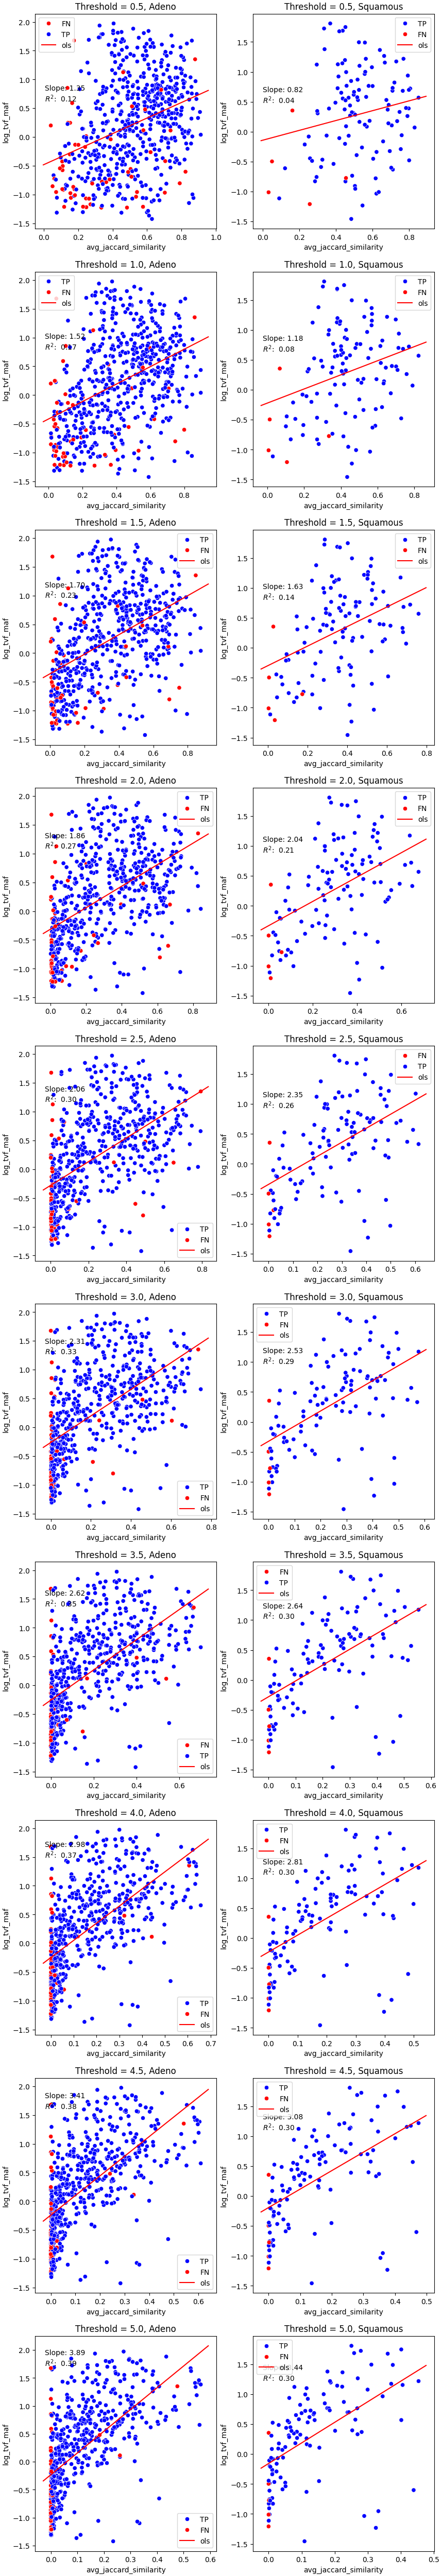

In [29]:
fig, axes = plt.subplots(s3_tissue_jaccard.thresholds.nunique(), 2, figsize=(10,64))
#axes = axes.flatten()
x = "avg_jaccard_similarity"
y = "log_tvf_maf"

for idx, threshold in enumerate(s3_tissue_jaccard.thresholds.unique()):

    adeno = s3_tissue_jaccard.query(' thresholds == @threshold and histological_subtype == "adenocarcinoma" ')
    
    sns.scatterplot(x=x, 
                    y=y, 
                    hue = "called",
                    data=adeno, 
                    palette={"TP":"blue", "FN":"red"},
                    ax = axes[idx,0])
    
    ## linear regression
    model = sm.ols('log_tvf_maf ~ avg_jaccard_similarity', data=adeno).fit()
    intercept, slope = model.params
    r_squared = model.rsquared

    ## generate regression line
    x_vals = np.array(axes[idx,0].get_xlim())
    y_vals = intercept + slope * x_vals

    axes[idx,0].plot(x_vals, y_vals, linestyle='-', color='red', label="ols")
    axes[idx,0].text(np.quantile(x_vals,0.01) , np.quantile(y_vals, 0.85) , f"Slope: {slope:.2f}\n$R^2$: {r_squared: .2f}")

    axes[idx,0].set_title(f"Threshold = {threshold}, Adeno")
    axes[idx,0].legend()    

    #################
    squamous = s3_tissue_jaccard.query(' thresholds == @threshold and histological_subtype == "squamous_cell_carcinoma" ')
    
    sns.scatterplot(x=x, 
                    y=y, 
                    hue = "called",
                    data=squamous, 
                    palette={"TP":"blue", "FN":"red"},
                    ax = axes[idx,1])
    
    ## linear regression
    model = sm.ols('log_tvf_maf ~ avg_jaccard_similarity', data=squamous).fit()
    intercept, slope = model.params
    r_squared = model.rsquared

    ## generate regression line
    x_vals = np.array(axes[idx,1].get_xlim())
    y_vals = intercept + slope * x_vals

    axes[idx,1].plot(x_vals, y_vals, linestyle='-', color='red', label="ols")
    axes[idx,1].text(np.quantile(x_vals,0.01) , np.quantile(y_vals, 0.85) , f"Slope: {slope:.2f}\n$R^2$: {r_squared: .2f}")

    axes[idx,1].set_title(f"Threshold = {threshold}, Squamous")
    axes[idx,1].legend()    

In [30]:
on_off_tissue_mutiplier.keys()

dict_keys(['mutiplier_1', 'mutiplier_2', 'mutiplier_3', 'mutiplier_4', 'mutiplier_5'])

In [31]:
on_off_tissue_mutiplier['mutiplier_1']['snr_1.0'].index

Index(['s3_region_26389', 's3_region_22508', 's3_region_22604',
       's3_region_26760', 's3_region_17285', 's3_region_8296',
       's3_region_27052', 's3_region_19545', 's3_region_23501',
       's3_region_15145',
       ...
       'merged_462', 'merged_184', 's3_region_3718', 's3_region_13486',
       's3_region_27348', 's3_region_27149', 's3_region_8257',
       's3_region_16209', 's3_region_8258', 's3_region_19'],
      dtype='object', length=3598)

## Region correlation (high MAF vs. low MAF)

In [97]:
abs_weight_quantile = 0.3
freq_threshold = 0.2
region_classification = {}

for key, val in on_off_tissue_mutiplier['mutiplier_3'].items():
    
    val = val.\
        reset_index(names="region_id").\
        merge(s3_v4_model, on="region_id",how='left')


    ## Classify regions
    hi_freq_lo_wt = val.query('And >= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    hi_freq_hi_wt = val.query('And >= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id
    
    lo_freq_lo_wt = val.query('And < @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    lo_freq_hi_wt = val.query('And < @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id

    region_classification[key] = {"hi_freq_lo_wt": hi_freq_lo_wt, ## signals in tissue that are NOT captured by the model
                                  "hi_freq_hi_wt": hi_freq_hi_wt, ## signals in tissue that are captuered by the model
                                  "lo_freq_lo_wt": lo_freq_lo_wt, ## signals in plasma that are NOT captured by the model
                                  "lo_freq_hi_wt": lo_freq_hi_wt} ## signals in plasma that are captureed by the model

In [98]:
def maf_label(x, high_maf = 0.7, low_maf = 0.5):
    if x >= high_maf:
        return "high"
    if x <= low_maf:
        return "low"
    else:
        return "other"

In [99]:
np.log10(5)

0.6989700043360189

In [100]:
df_lung_meta = df_lung_meta.\
     assign(log10_tvf_maf = lambda df: np.log10(df["tvf_max_maf_pct"])).\
     assign(MAF = lambda df: df["log10_tvf_maf"].map(maf_label))

high_maf_id = df_lung_meta.query('MAF == "high"').index
    #query('histological_subtype == "adenocarcinoma" ').\
    
print(len(high_maf_id))

low_maf_id = df_lung_meta.query('MAF == "low"').index
    #query('histological_subtype == "adenocarcinoma" ').\
    #query('MAF == "low"').index

print(len(low_maf_id))

219
445


In [101]:
freq_threshold_reverse = 0.2

region_anno = pd.DataFrame({"region_id": df_lung.columns}).\
    assign(mutiplier_1 = lambda df: np.where(df['region_id'].isin(on_off_tissue_mutiplier['mutiplier_1']['snr_1.0'].query('And <= @freq_threshold_reverse').index), "yes","no"))

region_class = []
for region in region_anno.region_id:
    if region in list(region_classification['snr_1.0']['hi_freq_lo_wt']):
        region_class.append('hi_freq_lo_wt')
    if region in list(region_classification['snr_1.0']['hi_freq_hi_wt']):
        region_class.append('hi_freq_hi_wt')
    if region in list(region_classification['snr_1.0']['lo_freq_lo_wt']):
        region_class.append('lo_freq_lo_wt')
    if region in list(region_classification['snr_1.0']['lo_freq_hi_wt']):
         region_class.append('lo_freq_hi_wt')

region_anno = region_anno.assign(region_class = region_class).\
    assign(lo_freq_lo_wt = lambda df:np.where(df["region_class"] == 'lo_freq_lo_wt', "yes", "no"),
           lo_freq_hi_wt = lambda df:np.where(df["region_class"] == 'lo_freq_hi_wt', "yes", "no")).\
    set_index("region_id")

region_anno.head()

mutiplier_1   region_class lo_freq_lo_wt lo_freq_hi_wt
region_id                                                             
s3_region_26389          no  hi_freq_lo_wt            no            no
s3_region_22508          no  hi_freq_lo_wt            no            no
s3_region_22604          no  hi_freq_hi_wt            no            no
s3_region_26760          no  hi_freq_lo_wt            no            no
s3_region_17285          no  hi_freq_hi_wt            no            no

In [102]:
high_maf_region_corr = df_lung.query('index.isin(@high_maf_id)').\
    corr()

low_maf_region_corr = df_lung.query('index.isin(@low_maf_id)').\
    corr()    

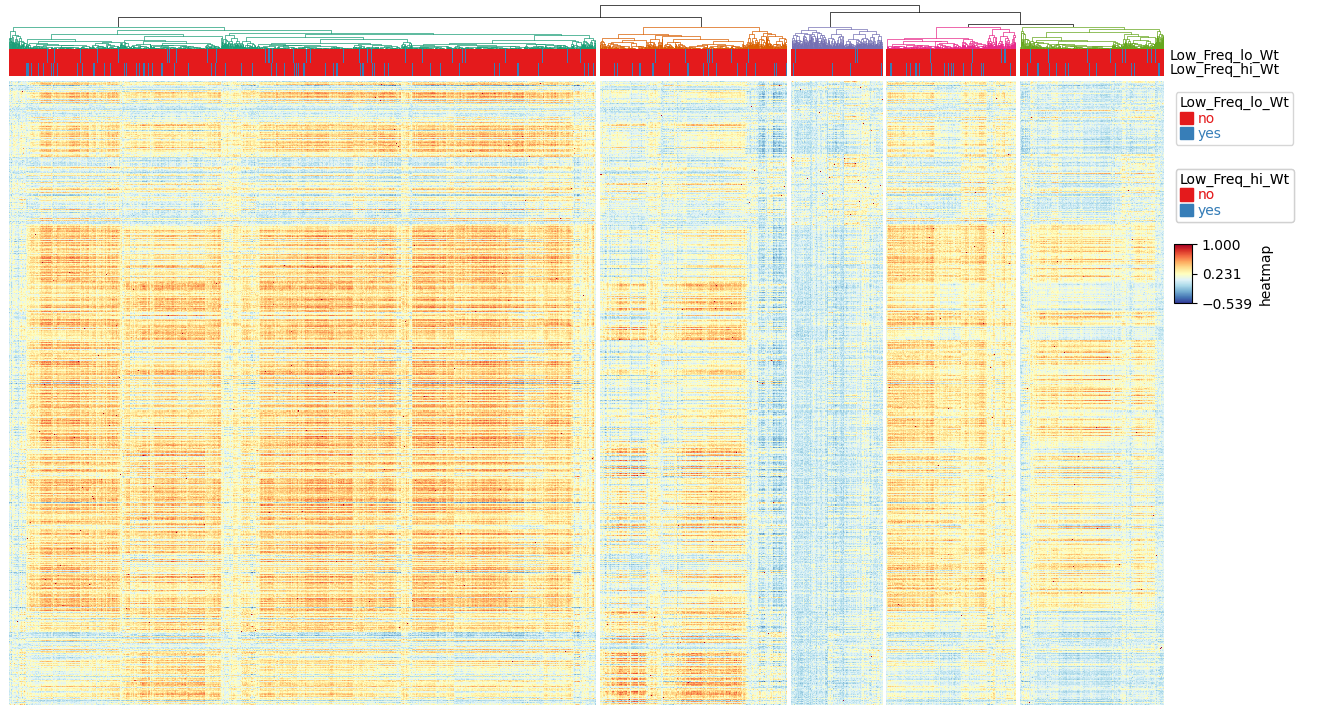

In [103]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
#col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  #Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  #axis=1, 
                                  #verbose=False)

col_annot = pyc.HeatmapAnnotation(#Personal=pyc.anno_simple(region_anno.mutiplier_1, cmap="Set2"),
                                  #Region_class = pyc.anno_simple(region_anno.region_class, cmap="Set1"),
                                  Low_Freq_lo_Wt = pyc.anno_simple(region_anno.lo_freq_lo_wt, cmap="Set1"),
                                  Low_Freq_hi_Wt = pyc.anno_simple(region_anno.lo_freq_hi_wt, cmap="Set1"),
                                  axis=1, 
                                  verbose=False)

cm = pyc.ClusterMapPlotter(data=high_maf_region_corr, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=5, 
                           col_split_gap=1, 
                           col_cluster=True,
                           row_cluster=False,
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

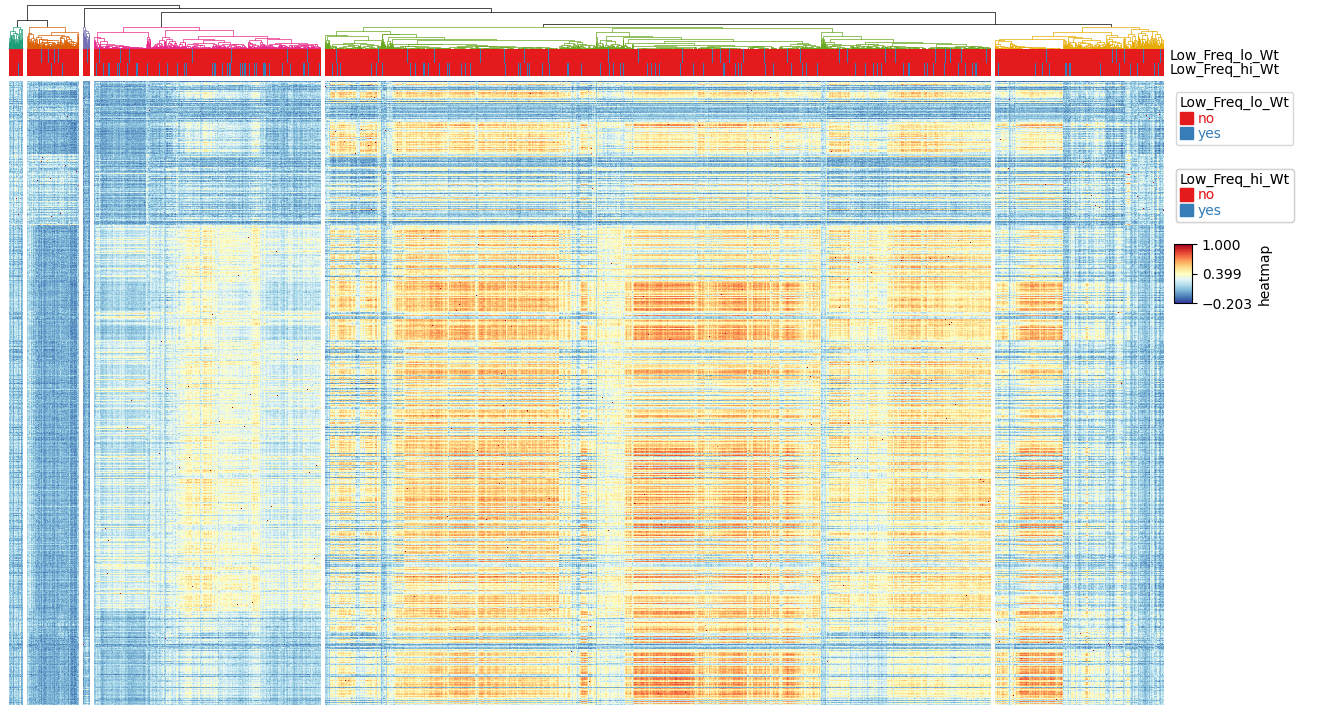

In [104]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
#col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  #Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  #axis=1, 
                                  #verbose=False)

col_annot = pyc.HeatmapAnnotation(#Personal=pyc.anno_simple(region_anno.mutiplier_1, cmap="Set2"),
                                  #Region_class = pyc.anno_simple(region_anno.region_class, cmap="Set1"),
                                  Low_Freq_lo_Wt = pyc.anno_simple(region_anno.lo_freq_lo_wt, cmap="Set1"),
                                  Low_Freq_hi_Wt = pyc.anno_simple(region_anno.lo_freq_hi_wt, cmap="Set1"),
                                  axis=1, 
                                  verbose=False)

cm = pyc.ClusterMapPlotter(data=low_maf_region_corr, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=6, 
                           col_split_gap=1, 
                           col_cluster=True,
                           row_cluster=False,
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()